In [25]:
#================================================================
#Statistical Analysis Dataframe Creation
#================================================================

In [26]:
#Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import preprocessing as pre
import tropycal.tracks as tracks
import tropycal as tc
import datetime
import scipy.stats as stats
import xarray as xr
import geopandas as gpd
import netCDF4

from scipy.stats import poisson
from scipy.stats import pearsonr
from geopy.distance import distance
from geopy import Point
from geopy import distance


pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [27]:
#File paths

#observational data
obs_file_path = "D:\Masters_Thesis\Data_For_Analysis\observations\ibtracs.SI.list.v04r00.csv"

#control_1950
control_file_path_e1 = "D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc"
control_file_path_e2 = "D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\\r2i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r2i1p2f1_gr_19500101-20501231.nc"

#highres_future
future_file_path_e1 = "D:\Masters_Thesis\Data_For_Analysis\highres-future\EC-Earth_Consortium\EC-Earth3p-HR\\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_highres-future_r1i1p2f1_gr_20150101-20501231.nc"
future_file_path_e2 = "D:\Masters_Thesis\Data_For_Analysis\highres-future\EC-Earth_Consortium\EC-Earth3p-HR\\r2i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_highres-future_r2i1p2f1_gr_20150101-20501231.nc"


In [28]:
from global_land_mask import is_ocean

In [29]:
def normalize_longitude(longitude):
        """
        Normalize the longitude value to be within -180 and 180 degrees.
        """
        while longitude > 180:
            longitude -= 360
        while longitude < -180:
            longitude += 360
        return longitude

def read_storms_filtered(file_path, hemi, basin):
    """
    For a given file path, read the storms from the file.
    """

    # Read the netcdf file
    storms = list(pre.load_cmor(file_path))

    # Check the metadata to discover which algorithm this is, and hence
    # what feature variable is tracked
    with netCDF4.Dataset(file_path, 'r') as nc:
        track_algorithm = nc.getncattr('algorithm')
        if track_algorithm == 'TRACK':
            track_extra = nc.getncattr('algorithm_extra')
            if track_extra == 'T63avg':
                feature_variable = 'vortmean_T63'
            else:
                feature_variable = 'rv850_T42'
        elif track_algorithm == 'TempestExtremes':
            feature_variable = 'psl'
        else:
            raise Exception('Unrecognised algorithm in netcdf file '+file_path)

    if hemi.lower() == 'nh':
        months = pre.months_nh
        lat_min, lat_max, lon_min, lon_max = pre.basin_bounds[basin]
    elif hemi.lower() == 'sh':
        months = pre.months_sh
        lat_min, lat_max, lon_min, lon_max = pre.basin_bounds[basin]
    else:
        raise ValueError('Invalid hemisphere argument. Must be "NH" or "SH"')

    # Filter out storms that do not meet the specified criteria
    filtered_storms = []
    storm_track_points = []  # List to store the storm track points
    for storm in storms:
        # Check if the storm lasted longer than 2 days, check that the 250 hpa and 850 hpa variables are not none, check the difference between 250 hpa and 850 hpa is greater than 0, indicating a warm core
        if storm._storm_vmax_in_basin(basin) and storm.lifetime >= 2 and \
            storm.t63_850_250_diff_max is not None and storm.t63_850_250_diff_max > 0:
            # Normalize the longitude of the first storm track point
            lon = normalize_longitude(storm.obs[0].lon)

           # Check if the normalized longitude and latitude are over the ocean
            if lon <= 180:  # Ensure the longitude is within the valid range
                if is_ocean(storm.obs[0].lat, lon):
                    filtered_storms.append(storm)
                    storm_track_points.extend(storm.obs)

    return filtered_storms, feature_variable, months, storm_track_points

In [30]:
#Load data from files

hemi = 'SH'
basin = 'si'

#observational data
ibtracs = tracks.TrackDataset(basin='south_indian', source='ibtracs', ibtracs_url=obs_file_path, ibtracs_mode="wmo")


#control_1950
control_storms_e1, feature_variable, months, storm_track_points = read_storms_filtered(control_file_path_e1, hemi, basin)
control_storms_e2, feature_variable, months, storm_track_points = read_storms_filtered(control_file_path_e2, hemi, basin)

#highres_future
future_storms_e1, feature_variable, months, storm_track_points = read_storms_filtered(future_file_path_e1, hemi,basin)
future_storms_e2, feature_variable, months, storm_track_points = read_storms_filtered(future_file_path_e2, hemi,basin)


--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (15.85 seconds)
fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc
fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r2i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r2i1p2f1_gr_19500101-20501231.nc
fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\highres-future\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_highres-future_r1i1p2f1_gr_20150101-20501231.nc
fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\highres-future\EC-Earth_Consortium\EC-Earth3p-HR\r2i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_highres-future_r2i1p2f1_gr_20150101-20501231.nc


In [31]:
def create_storm_dataframe(storms):
    # Create an empty dictionary to hold the storm data
    storm_data = { "lat": [], "lon": []}

    # Loop over the filtered storms and add the relevant information to the dictionary
    for storm in storms:
        
        # Iterate over the storm observations
        for obs in storm.obs:
            # Access the latitude and longitude values using appropriate attributes or methods
            latitude = obs.lat
            longitude = obs.lon

            storm_data["lat"].append(latitude)
            storm_data["lon"].append(longitude)


    # Create a DataFrame from the storm data dictionary
    storm_df = pd.DataFrame(storm_data)
    
    return storm_df

In [32]:
#Reading in IBTRaCS data for SWIO region and filter by time period
ibtracs_filter_df = ibtracs.filter_storms(year_range=(1980,2015), date_range=('7/1','6/30'), return_keys=False)


#Reorder columns of filtered dataframe
ibtracs_filter_df.reindex(columns=['season', 'stormid', 'vmax', 'mslp', 'type','lat', 'lon', 'date', 'ace'])
print(ibtracs_filter_df)


#Adjust date format
ibtracs_filter_df['date'] = pd.to_datetime(ibtracs_filter_df['date'])


bystorm = (ibtracs_filter_df.groupby(['season', 'stormid'], as_index=False)
         .agg(start_date=('date', lambda s: s.min().normalize()),
              end_date=('date', lambda s: s.max().normalize()),
              vmax_max=('vmax', 'max'),
              mslp_max=('mslp', 'min')
             )
         .assign(days=lambda d: d['end_date'].sub(d['start_date']).dt.days,
                 start_year=lambda d: d['start_date'].dt.year,
                 end_year=lambda d: d['end_date'].dt.year)
       )
bystorm = bystorm.rename(columns={'vmax_max': 'vmax'})
bystorm = bystorm.rename(columns={'mslp_max': 'mslp'})


print(bystorm)



# Rename columns
df1 = bystorm.rename(columns={'days': 'duration'})

#convert knots to m/s
df1['vmax'] = df1['vmax'] * 0.514444

# Drop the start_year and end_year columns
df1 = df1.drop(['start_year', 'end_year'], axis=1)


       vmax    mslp type      lat      lon                date  season  \
0        32  1000.0   TD -14.0000  80.0000 1980-01-02 00:00:00    1980   
1        28  1005.0   TD -11.0000  59.0000 1980-01-05 06:00:00    1980   
2        22  1005.0   TD -13.6000  66.4000 1980-01-08 12:00:00    1980   
3        32  1000.0   TD -20.3000  51.0000 1980-01-12 06:00:00    1980   
4        32  1000.0   TD -26.0000  47.2000 1980-01-11 06:00:00    1980   
...     ...     ...  ...      ...      ...                 ...     ...   
11804    28  1008.0   TD -27.7000  65.3000 2015-12-15 12:00:00    2016   
11805    22  1010.0   TD -28.1500  65.4000 2015-12-15 18:00:00    2016   
11806    22  1011.0   TD -28.7500  65.7000 2015-12-16 00:00:00    2016   
11807    22  1011.0   TD -29.5571  66.5429 2015-12-16 06:00:00    2016   
11808    22  1012.0   TD -30.4000  67.9200 2015-12-16 12:00:00    2016   

             stormid  ace  
0      1980002S15081  0.0  
1      1980005S11059  0.0  
2      1980009S14066  0.0  

In [33]:

# Get the year of the start_date
df1['year'] = df1['start_date'].dt.year

# Define function to create season range column
def set_season(row):
    if row['start_date'].month >= 10:
        return row['year']
    else:
        return row['year'] - 1


# Apply the function to each row to create a new column
df1['season'] = df1.apply(set_season, axis=1)


# Drop the first four rows of the dataframe
df1 = df1.drop([0, 1, 2, 3, 4, 5, 6, 7])

# Drop the last two rows of the dataframe
df1 = df1.drop(df1.tail(2).index)

#Drop the year column
df1.drop(['year'], axis=1, inplace=True)

print(df1)



     season        stormid start_date   end_date       vmax   mslp  duration
8      1980  1980308S05102 1980-11-03 1980-11-10  61.733280  940.0         7
9      1980  1980348S11116 1980-12-13 1980-12-22  64.305500  940.0         9
10     1980  1981094S06094 1981-04-05 1981-04-15  55.045508  940.0        10
11     1980  1981142S08091 1981-05-24 1981-05-30  37.554412  973.0         6
12     1981  1981306S03096 1981-11-13 1981-11-20  30.866640  976.0         7
..      ...            ...        ...        ...        ...    ...       ...
362    2014  2015036S20038 2015-02-05 2015-02-11  31.895528  978.0         6
363    2014  2015050S11094 2015-02-20 2015-03-01  28.294420  970.0         9
364    2014  2015064S14052 2015-03-05 2015-03-11  25.722200  993.0         6
365    2014  2015092S18074 2015-04-02 2015-04-17  43.727740  962.0        15
366    2014  2015094S10087 2015-04-04 2015-04-08  55.045508  953.0         4

[359 rows x 7 columns]


In [34]:
import geopandas as gpd
from shapely.geometry import box
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from rtree import index
from scipy.spatial import cKDTree

import numpy as np
from scipy.spatial import cKDTree



In [35]:
from geopy.distance import distance
from geopy.exc import GeopyError

def create_storm_dataframe(storms):
    # Create an empty dictionary to hold the storm data
    storm_data = {"stormid": [], "season":[], "start_date": [], "end_date": [], "duration": [], "vmax": [], "mslp":[]}

    def mslp_max(obs):
        # The maximum central pressure reached by the storm during its lifetime (set to -999 if no records are available) 
        mslps = [ob.mslp for ob in obs if ob.mslp != 1e12]
        if not mslps:
            return -999
        return min(mslps)   

    # Loop over the filtered storms and add the relevant information to the dictionary
    for storm in storms:

        # Determine the start year of the storm
        start_year = storm.genesis_date.year
        # Determine the start month of the storm
        start_month = storm.genesis_date.month
        # Determine the end year of the storm
        end_year = storm.lysis_date.year
        # Determine the end month of the storm
        end_month = storm.lysis_date.month
        
        # Determine the season
        if start_month >= 10 or start_month < 6:
            season = start_year
        else:
            season = start_year - 1
        
        mslp = mslp_max(storm.obs)

        storm_data["stormid"].append(storm.snbr)
        storm_data["season"].append(season)
        storm_data["start_date"].append(storm.genesis_date)
        storm_data["end_date"].append(storm.lysis_date)
        storm_data["duration"].append(storm.lifetime)
        storm_data["vmax"].append(storm.vmax)
        storm_data["mslp"].append(mslp)

    
    
    # Create a DataFrame from the storm data dictionary
    storm_df = pd.DataFrame(storm_data)
    
    return storm_df



In [36]:
#create the dataframes
#observational
obs_df = df1

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(obs_df)


     season        stormid start_date   end_date    vmax    mslp  duration
8      1980  1980308S05102 1980-11-03 1980-11-10  61.733   940.0         7
9      1980  1980348S11116 1980-12-13 1980-12-22  64.305   940.0         9
10     1980  1981094S06094 1981-04-05 1981-04-15  55.046   940.0        10
11     1980  1981142S08091 1981-05-24 1981-05-30  37.554   973.0         6
12     1981  1981306S03096 1981-11-13 1981-11-20  30.867   976.0         7
13     1981  1981351S12060 1981-12-17 1981-12-25  41.156   954.0         8
14     1981  1981363S10079 1981-12-29 1982-01-06  15.433   997.0         8
15     1981  1982005S10105 1982-01-06 1982-01-18  65.334   898.0        12
16     1981  1982030S15065 1982-01-31 1982-02-05  25.722   984.0         5
17     1981  1982031S20048 1982-02-01 1982-02-01  20.578   991.0         0
18     1981  1982036S16060 1982-02-05 1982-02-06  25.722   984.0         1
19     1981  1982043S12073 1982-02-12 1982-02-14  15.433   997.0         2
20     1981  1982054S2305

In [37]:

#control_1950
control_df_e1 = create_storm_dataframe(control_storms_e1)

start_season = 1980
end_season = 2015

control_df_e1 = control_df_e1[(control_df_e1['season'] >= start_season) & (control_df_e1['season'] <= end_season)]

control_df_e1 = control_df_e1.drop([355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365])
control_df_e1 = control_df_e1.drop(control_df_e1.tail(8).index)

control_df_e1

,stormid,season,start_date,end_date,duration,vmax,mslp
368,1564,1980,1980-10-14 18:00:00,1980-10-30 18:00:00,16,25.036180,1004.119019
369,1565,1980,1980-10-25 00:00:00,1980-11-13 00:00:00,19,22.154181,1006.229980
370,1566,1980,1980-11-09 18:00:00,1980-11-28 18:00:00,19,27.925930,1005.453003
371,1568,1980,1980-11-19 12:00:00,1980-12-17 12:00:00,28,19.798080,1005.041992
372,1570,1980,1980-12-04 00:00:00,1981-01-01 00:00:00,28,26.184690,995.890625
...,...,...,...,...,...,...,...
760,3278,2015,2015-02-09 00:00:00,2015-02-18 00:00:00,9,25.098450,995.438171
761,3282,2015,2015-02-11 12:00:00,2015-03-08 12:00:00,25,45.184559,976.351685
762,3295,2015,2015-03-31 00:00:00,2015-04-22 00:00:00,22,28.896210,999.756592
763,3301,2015,2015-05-04 00:00:00,2015-05-22 00:00:00,18,19.929810,1004.820984


In [38]:

#control_1950
control_df_e2 = create_storm_dataframe(control_storms_e2)

start_season = 1980
end_season = 2015

control_df_e2 = control_df_e2[(control_df_e2['season'] >= start_season) & (control_df_e2['season'] <= end_season)]
control_df_e2 = control_df_e2.drop([359,360,361,362,363, 364])
control_df_e2 = control_df_e2.drop(control_df_e2.tail(5).index)

control_df_e2

,stormid,season,start_date,end_date,duration,vmax,mslp
365,1559,1980,1980-10-10 06:00:00,1980-11-25 06:00:00,46,20.218901,1003.994019
366,1561,1980,1980-11-08 12:00:00,1980-11-16 12:00:00,8,17.525030,1007.585999
367,1563,1980,1980-11-04 00:00:00,1980-12-20 00:00:00,46,22.748720,1004.270020
368,1566,1980,1980-12-01 06:00:00,1980-12-29 06:00:00,28,24.659800,998.629272
369,1568,1980,1980-12-07 06:00:00,1980-12-31 06:00:00,24,29.135731,995.771606
...,...,...,...,...,...,...,...
758,3314,2015,2015-01-28 00:00:00,2015-02-08 00:00:00,11,26.888670,995.568115
759,3316,2015,2015-02-01 18:00:00,2015-02-25 18:00:00,24,37.694939,983.279724
760,3323,2015,2015-02-22 06:00:00,2015-03-09 06:00:00,15,31.805300,993.893494
761,3328,2015,2015-03-20 18:00:00,2015-04-13 18:00:00,24,19.310070,1005.280029


In [39]:
control_df = pd.concat([control_df_e1, control_df_e2])
control_df = control_df.reset_index(drop=True)

control_df

,stormid,season,start_date,end_date,duration,vmax,mslp
0,1564,1980,1980-10-14 18:00:00,1980-10-30 18:00:00,16,25.036180,1004.119019
1,1565,1980,1980-10-25 00:00:00,1980-11-13 00:00:00,19,22.154181,1006.229980
2,1566,1980,1980-11-09 18:00:00,1980-11-28 18:00:00,19,27.925930,1005.453003
3,1568,1980,1980-11-19 12:00:00,1980-12-17 12:00:00,28,19.798080,1005.041992
4,1570,1980,1980-12-04 00:00:00,1981-01-01 00:00:00,28,26.184690,995.890625
...,...,...,...,...,...,...,...
790,3314,2015,2015-01-28 00:00:00,2015-02-08 00:00:00,11,26.888670,995.568115
791,3316,2015,2015-02-01 18:00:00,2015-02-25 18:00:00,24,37.694939,983.279724
792,3323,2015,2015-02-22 06:00:00,2015-03-09 06:00:00,15,31.805300,993.893494
793,3328,2015,2015-03-20 18:00:00,2015-04-13 18:00:00,24,19.310070,1005.280029


In [40]:
'''# Merge the dataframes based on the storm_id and stormid columns
merged_df = pd.merge(df, control_df, left_on='storm_id', right_on='stormid')

# Rename the min_distance_km column as landfall
merged_df = merged_df.rename(columns={'min_distance_km': 'landfall'})

# Drop the redundant storm_id column
merged_df = merged_df.drop('storm_id', axis=1)

# Reorder the columns
column_order = [col for col in merged_df.columns if col != 'landfall'] + ['landfall']
control_landfall_df = merged_df[column_order]

# Print the merged dataframe with the reordered columns
print(control_landfall_df)'''


"# Merge the dataframes based on the storm_id and stormid columns\nmerged_df = pd.merge(df, control_df, left_on='storm_id', right_on='stormid')\n\n# Rename the min_distance_km column as landfall\nmerged_df = merged_df.rename(columns={'min_distance_km': 'landfall'})\n\n# Drop the redundant storm_id column\nmerged_df = merged_df.drop('storm_id', axis=1)\n\n# Reorder the columns\ncolumn_order = [col for col in merged_df.columns if col != 'landfall'] + ['landfall']\ncontrol_landfall_df = merged_df[column_order]\n\n# Print the merged dataframe with the reordered columns\nprint(control_landfall_df)"

In [41]:
#highres_future
future_df_e1 = create_storm_dataframe(future_storms_e1)
start_season = 2015
end_season = 2050

future_df_e1 = future_df_e1[(future_df_e1['season'] >= start_season) & (future_df_e1['season'] <= end_season)]

# Drop the last rows of the dataframe
future_df_e1 = future_df_e1.drop([0, 1, 2, 3, 4, 5, 6, 7, 8 ])
future_df_e1 = future_df_e1.drop(future_df_e1.tail(2).index)

future_df_e1


,stormid,season,start_date,end_date,duration,vmax,mslp
9,43,2015,2015-10-14 00:00:00,2015-11-11 00:00:00,28,22.630079,1003.612976
10,45,2015,2015-11-17 12:00:00,2015-12-05 12:00:00,18,19.932341,1003.304993
11,49,2016,2016-01-01 00:00:00,2016-01-12 00:00:00,11,23.929560,1000.276978
12,52,2016,2016-01-07 00:00:00,2016-01-14 00:00:00,7,19.241051,1002.245972
13,53,2016,2016-01-14 18:00:00,2016-01-29 18:00:00,15,21.863951,999.861084
...,...,...,...,...,...,...,...
296,1535,2050,2050-01-01 00:00:00,2050-01-13 00:00:00,12,22.858391,1001.216003
297,1544,2050,2050-02-10 18:00:00,2050-02-25 18:00:00,15,27.120300,991.109924
298,1551,2050,2050-03-09 12:00:00,2050-04-08 12:00:00,30,29.413361,996.879700
299,1552,2050,2050-03-12 06:00:00,2050-03-28 06:00:00,16,31.633760,997.377930


In [42]:
#highres_future
future_df_e2 = create_storm_dataframe(future_storms_e2)
start_season = 2015
end_season = 2050

future_df_e2 = future_df_e2[(future_df_e2['season'] >= start_season) & (future_df_e2['season'] <= end_season)]

future_df_e2 = future_df_e2.drop([0, 1, 2, 3, 4, 5 ])
#future_df_e2 = future_df_e2.drop(future_df_e2.tail(0).index)

future_df_e2

,stormid,season,start_date,end_date,duration,vmax,mslp
6,45,2015,2015-12-17 12:00:00,2015-12-28 12:00:00,11,17.462740,1006.096008
7,49,2016,2016-01-10 00:00:00,2016-01-31 00:00:00,21,47.658001,983.228271
8,55,2016,2016-02-08 18:00:00,2016-03-31 18:00:00,52,48.284000,980.643311
9,56,2016,2016-02-13 06:00:00,2016-03-04 06:00:00,20,57.173611,936.622925
10,60,2016,2016-03-02 12:00:00,2016-03-07 12:00:00,5,11.992170,1008.182007
...,...,...,...,...,...,...,...
283,1514,2050,2050-02-10 12:00:00,2050-02-19 12:00:00,9,26.020321,998.193481
284,1515,2050,2050-02-15 12:00:00,2050-03-02 12:00:00,15,28.174219,999.641907
285,1519,2050,2050-03-02 12:00:00,2050-04-06 12:00:00,35,29.996990,989.189270
286,1520,2050,2050-03-05 18:00:00,2050-03-22 18:00:00,17,40.640919,972.741028


In [43]:
future_df = pd.concat([future_df_e1, future_df_e2])
future_df = future_df.reset_index(drop=True)
future_df

,stormid,season,start_date,end_date,duration,vmax,mslp
0,43,2015,2015-10-14 00:00:00,2015-11-11 00:00:00,28,22.630079,1003.612976
1,45,2015,2015-11-17 12:00:00,2015-12-05 12:00:00,18,19.932341,1003.304993
2,49,2016,2016-01-01 00:00:00,2016-01-12 00:00:00,11,23.929560,1000.276978
3,52,2016,2016-01-07 00:00:00,2016-01-14 00:00:00,7,19.241051,1002.245972
4,53,2016,2016-01-14 18:00:00,2016-01-29 18:00:00,15,21.863951,999.861084
...,...,...,...,...,...,...,...
569,1514,2050,2050-02-10 12:00:00,2050-02-19 12:00:00,9,26.020321,998.193481
570,1515,2050,2050-02-15 12:00:00,2050-03-02 12:00:00,15,28.174219,999.641907
571,1519,2050,2050-03-02 12:00:00,2050-04-06 12:00:00,35,29.996990,989.189270
572,1520,2050,2050-03-05 18:00:00,2050-03-22 18:00:00,17,40.640919,972.741028


In [44]:
#observational data
obs_storms_per_season = obs_df.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#obs_storms_per_season["season"] = obs_storms_per_season["season"].str[:4].astype(int)
#obs_storms_per_season["frequency"] = obs_storms_per_season["frequency"].astype(int)
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(obs_storms_per_season)

    season  frequency
0     1980          4
1     1981         11
2     1982          7
3     1983         14
4     1984         10
5     1985         12
6     1986          5
7     1987          9
8     1988         12
9     1989          9
10    1990          9
11    1991         15
12    1992         13
13    1993         15
14    1994         13
15    1995         12
16    1996         12
17    1997          8
18    1998          8
19    1999         11
20    2000          8
21    2001         12
22    2002         13
23    2003         10
24    2004         10
25    2005          6
26    2006         11
27    2007         12
28    2008         10
29    2009         10
30    2010          4
31    2011         11
32    2012         10
33    2013         11
34    2014         12


In [45]:
#Create storms per season dataframes
#control_1950
control_storms_per_season_e1 = control_df_e1.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#control_storms_per_season["season"] = control_storms_per_season["season"].str[:4].astype(int)
#control_storms_per_season["frequency"] = control_storms_per_season["frequency"].astype(int)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(control_storms_per_season_e1)




    season  frequency
0     1980          5
1     1981         14
2     1982         11
3     1983         16
4     1984         12
5     1985         12
6     1986          9
7     1987         14
8     1988         10
9     1989         12
10    1990          8
11    1991         11
12    1992          8
13    1993         11
14    1994          7
15    1995         12
16    1996         10
17    1997         14
18    1998         15
19    1999          6
20    2000          9
21    2001         10
22    2002         13
23    2003          7
24    2004         11
25    2005         12
26    2006         13
27    2007         13
28    2008         12
29    2009         13
30    2010          7
31    2011         12
32    2012         14
33    2013         11
34    2014         15
35    2015          8


In [46]:
#Create storms per season dataframes
#control_1950
control_storms_per_season_e2 = control_df_e2.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#control_storms_per_season["season"] = control_storms_per_season["season"].str[:4].astype(int)
#control_storms_per_season["frequency"] = control_storms_per_season["frequency"].astype(int)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(control_storms_per_season_e2)

    season  frequency
0     1980          6
1     1981         10
2     1982         12
3     1983         14
4     1984         12
5     1985         14
6     1986         18
7     1987         12
8     1988         15
9     1989          9
10    1990         10
11    1991          7
12    1992          6
13    1993         11
14    1994         12
15    1995         15
16    1996         15
17    1997          9
18    1998         11
19    1999         10
20    2000         11
21    2001         10
22    2002         13
23    2003         11
24    2004         12
25    2005         12
26    2006         14
27    2007         11
28    2008         15
29    2009         13
30    2010          3
31    2011         12
32    2012         10
33    2013          3
34    2014         12
35    2015          8


In [47]:
#highres_future
future_storms_per_season_e1 = future_df_e1.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#future_storms_per_season["season"] = future_storms_per_season["season"].str[:4].astype(int)
#future_storms_per_season["frequency"] = future_storms_per_season["frequency"].astype(int)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(future_storms_per_season_e1)

    season  frequency
0     2015          2
1     2016          8
2     2017          5
3     2018         12
4     2019          7
5     2020         12
6     2021          7
7     2022          8
8     2023          6
9     2024         10
10    2025          8
11    2026         12
12    2027          8
13    2028         11
14    2029          6
15    2030          6
16    2031         10
17    2032          5
18    2033         12
19    2034          7
20    2035          4
21    2036         10
22    2037          6
23    2038          8
24    2039          7
25    2040          9
26    2041         13
27    2042          7
28    2043         12
29    2044          8
30    2045          9
31    2046          8
32    2047          7
33    2048          7
34    2049         10
35    2050          5


In [48]:
#highres_future
future_storms_per_season_e2 = future_df_e2.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#future_storms_per_season["season"] = future_storms_per_season["season"].str[:4].astype(int)
#future_storms_per_season["frequency"] = future_storms_per_season["frequency"].astype(int)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(future_storms_per_season_e2)

    season  frequency
0     2015          2
1     2016         11
2     2017         11
3     2018         10
4     2019          9
5     2020          7
6     2021         13
7     2022          7
8     2023          8
9     2024          7
10    2025          8
11    2026          7
12    2027          9
13    2028         10
14    2029          8
15    2030          7
16    2031          9
17    2032          8
18    2033          6
19    2034          9
20    2035          8
21    2036          5
22    2037          9
23    2038          7
24    2039          7
25    2040         10
26    2041          7
27    2042          7
28    2043         10
29    2044          2
30    2045          5
31    2046          7
32    2047          9
33    2048          6
34    2049          9
35    2050          8


In [49]:
#================================================================
#Statistical Analysis Function Creation
#================================================================

In [116]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable, Size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from mpl_toolkits.axes_grid1 import make_axes_locatable, Size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [149]:


import statsmodels.api as sm

def plot_regression(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1,2,figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1]})
    
    # Filter rows with valid values
    obs_data = obs_data[~np.isnan(obs_data[x_col]) & ~np.isnan(obs_data[y_col])]
    control_data = control_data[~np.isnan(control_data[x_col]) & ~np.isnan(control_data[y_col])]
    future_data = future_data[~np.isnan(future_data[x_col]) & ~np.isnan(future_data[y_col])]


    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = "black"

    # Create a linear regression plot for each dataset in a different subplot
    sns.regplot(data=obs_data, x=x_col, y=y_col, ax=axes[0], scatter_kws={'color': obs_color}, line_kws={'color': line_color}, ci=95)
    sns.regplot(data=control_data, x=x_col, y=y_col, ax=axes[1],scatter_kws={'color': control_color}, line_kws={'color': line_color}, ci=95)
    sns.regplot(data=future_data, x=x_col, y=y_col, ax=axes[1], scatter_kws={'color': future_color}, line_kws={'color': line_color}, ci=95)

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')

    # Compute and add Pearson correlation coefficients to the plot
    pearson_obs, _ = stats.pearsonr(obs_data[x_col], obs_data[y_col])
    pearson_ctrl, _ = stats.pearsonr(control_data[x_col], control_data[y_col])
    pearson_fut, _ = stats.pearsonr(future_data[x_col], future_data[y_col])

    # Perform linear regression and compute p-values for each dataset
    obs_x = sm.add_constant(obs_data[x_col])
    obs_model = sm.OLS(obs_data[y_col], obs_x).fit()
    obs_p_value = obs_model.pvalues[x_col]

    ctrl_x = sm.add_constant(control_data[x_col])
    ctrl_model = sm.OLS(control_data[y_col], ctrl_x).fit()
    ctrl_p_value = ctrl_model.pvalues[x_col]

    fut_x = sm.add_constant(future_data[x_col])
    fut_model = sm.OLS(future_data[y_col], fut_x).fit()
    fut_p_value = fut_model.pvalues[x_col]

    # Set the titles and Pearson correlation coefficient labels for each subplot
    #axes[0].set_title("Observational 1980-2014")
    #axes[0].annotate("Pearson r = {:.2f}, p-value = {:.4f}".format(pearson_obs, obs_p_value), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
    #axes[1].set_title("Control 1980-2014 & Future 2015-2050")
    #pearson_str = "Pearson r = {:.2f} & Pearson r = {:.5f}\np-value = {:.5f} & p-value = {:.3f}".format(pearson_ctrl, pearson_fut, ctrl_p_value, fut_p_value)
    #axes[1].annotate(pearson_str, xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
    #axes[0].set_title("Observations \n 1980-2014")
    #axes[1].set_title("Control - 1950s RF           Future - SSP5-8.5 RF \n 1980 - 2014                      2015 - 2050")


    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9, bottom=0.15)


    # Set all to same scale
    ymin = min(obs_data[y_col].min(), control_data[y_col].min(), future_data[y_col].min())
    ymax = max(obs_data[y_col].max(), control_data[y_col].max(), future_data[y_col].max())
    xmin = min(obs_data[x_col].min(), control_data[x_col].min(), future_data[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data[x_col].max(), future_data[x_col].max())

    # Create the text strings for the correlation coefficients
    ax1textstr = f'Pearson r: {pearson_obs:.4f}'
    ax2textstr = f'Pearson r: {pearson_ctrl:.4f}'
    ax3textstr = f'Pearson r: {pearson_fut:.4f}'

    # Create the text box properties
    props = dict(facecolor='white', alpha=0.5)
    
    # Add the text boxes to the plots
    # Add the text boxes to the plots
    axes[0].annotate(ax1textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axes[1].annotate(ax2textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axes[1].annotate(ax3textstr, xy=(1, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(-5, -5), textcoords='offset points', ha='right', va='top', bbox=props)

    # Add padding to the y-axis limits
    y_padding = 0.1 * (ymax - ymin)  # Adjust the padding factor as desired
    ymin -= y_padding
    ymax += y_padding

    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF           Future - SSP5-8.5 RF \n 1980 - 2014                      2015 - 2050")

    # Set the same y-axis limits for both subplots
    axes[0].set_ylim([ymin, ymax])
    axes[1].set_ylim([ymin, ymax])

    plt.rcParams.update({'font.size': 14})

    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\\linear_regression_{}_{}_2_ensemble.pdf'.format(x_label, y_label.replace('/', '_')), bbox_inches='tight')

    # Display the plot
    plt.show()


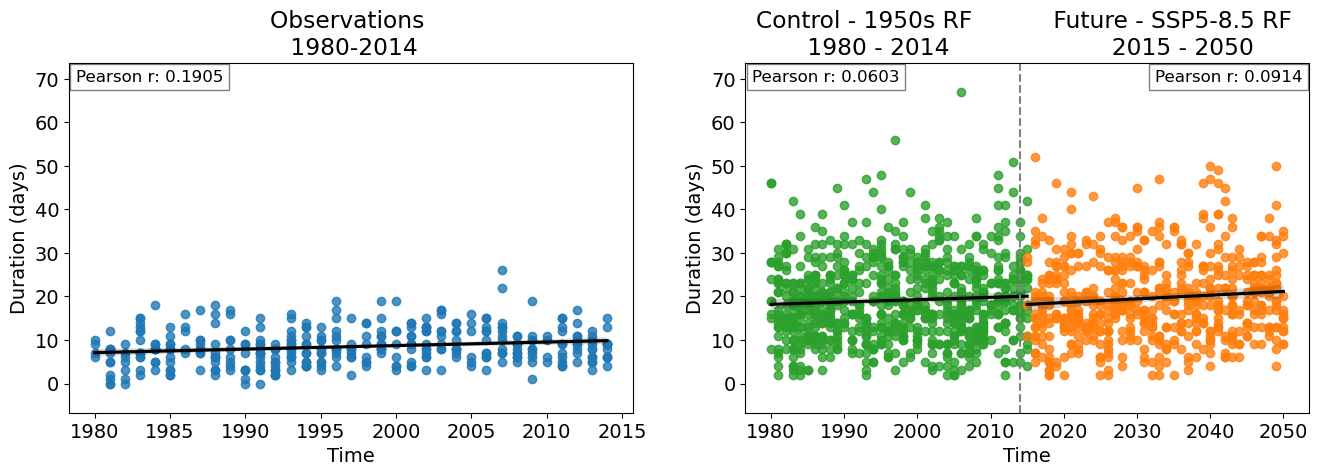

In [150]:

plot_regression("season", "duration", obs_df, control_df, future_df, "Time", "Duration (days)")

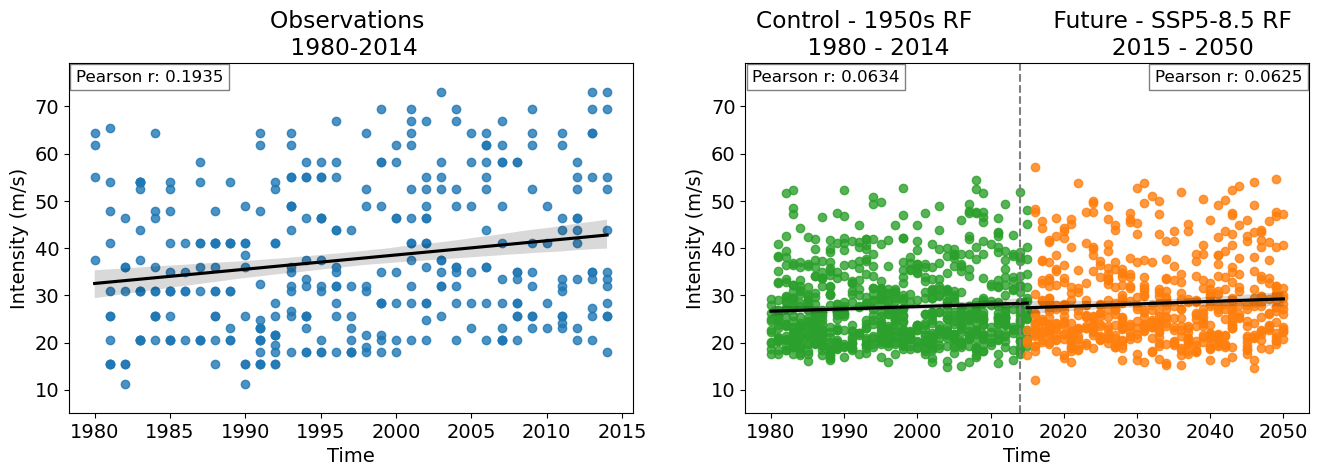

In [151]:
plot_regression("season","vmax",obs_df,control_df,future_df, "Time", "Intensity (m/s)")

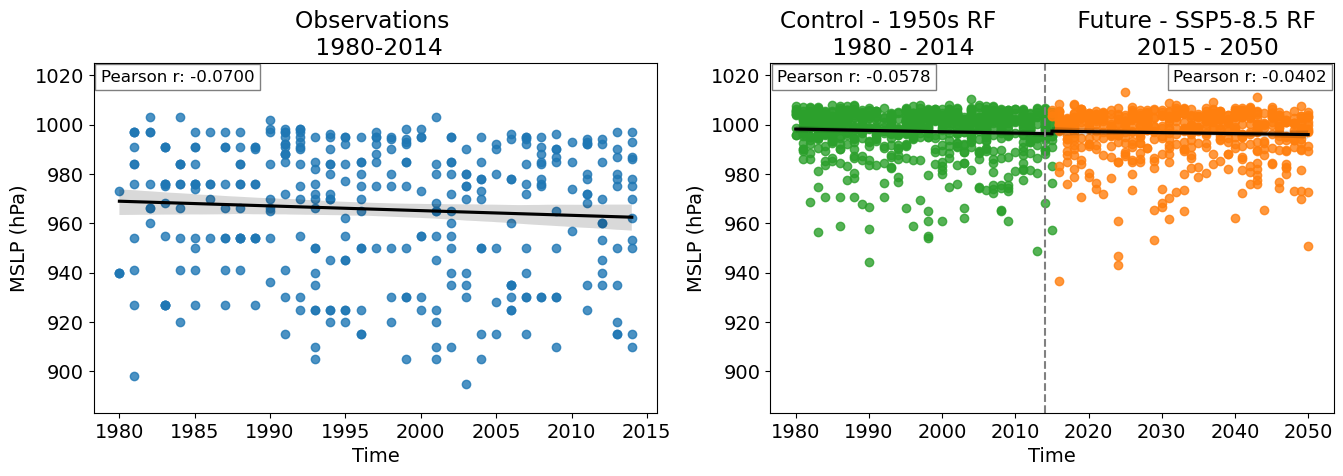

In [152]:
plot_regression("season", "mslp", obs_df, control_df, future_df, "Time", "MSLP (hPa)")

In [121]:

def plot_regression(x_col, y_col, obs_data, control_data1, control_data2, future_data1, future_data2, x_label, y_label):
    fig, axd = plt.subplot_mosaic([['left', 'upper center', 'upper right'],
                                   ['left', 'lower center', 'lower right']],
                                  figsize=(16, 7), layout="constrained", gridspec_kw={"width_ratios": [1, 1, 1], "height_ratios": [1, 1]})

    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = "black"

    # Observations plot
    sns.regplot(data=obs_data, x=x_col, y=y_col, ax=axd['left'], scatter_kws={'color': obs_color}, line_kws={'color': line_color})
    axd['left'].set_title("Observations")
    axd['left'].set_xlabel(x_label)
    axd['left'].set_ylabel(y_label)

    # Control 1 plot
    sns.regplot(data=control_data1, x=x_col, y=y_col, ax=axd['upper center'], scatter_kws={'color': control_color}, line_kws={'color': line_color})
    axd['upper center'].set_title("Control - r1i1p2f1")
    axd['upper center'].set_xlabel(x_label)
    axd['upper center'].set_ylabel(y_label)

    # Control 2 plot
    sns.regplot(data=control_data2, x=x_col, y=y_col, ax=axd['lower center'], scatter_kws={'color': control_color}, line_kws={'color': line_color})
    axd['lower center'].set_title("Control - r2i1p2f1")
    axd['lower center'].set_xlabel(x_label)
    axd['lower center'].set_ylabel(y_label)

    # Future 1 plot
    sns.regplot(data=future_data1, x=x_col, y=y_col, ax=axd['upper right'], scatter_kws={'color': future_color}, line_kws={'color': line_color})
    axd['upper right'].set_title("Future - r1i1p2f1")
    axd['upper right'].set_xlabel(x_label)
    axd['upper right'].set_ylabel(y_label)

    # Future 2 plot
    sns.regplot(data=future_data2, x=x_col, y=y_col, ax=axd['lower right'], scatter_kws={'color': future_color}, line_kws={'color': line_color})
    axd['lower right'].set_title("Future - r2i1p2f1")
    axd['lower right'].set_xlabel(x_label)
    axd['lower right'].set_ylabel(y_label)

    # Set the same y-axis limits for all subplots
    ymin = min(obs_data[y_col].min(), control_data1[y_col].min(), control_data2[y_col].min(),
               future_data1[y_col].min(), future_data2[y_col].min())
    ymax = max(obs_data[y_col].max(), control_data1[y_col].max(), control_data2[y_col].max(),
               future_data1[y_col].max(), future_data2[y_col].max())
    y_padding = 0.1 * (ymax - ymin)  # Adjust the padding factor as desired
    ymin -= y_padding
    ymax += y_padding

    for ax in axd.values():
        ax.set_ylim([ymin, ymax])

    

    #Calculate statistics
    pearson_obs, _ = stats.pearsonr(obs_data[x_col], obs_data[y_col])
    pearson_ctrl_1, _ = stats.pearsonr(control_data1[x_col], control_data1[y_col])
    pearson_ctrl_2, _ = stats.pearsonr(control_data2[x_col], control_data2[y_col])
    pearson_fut_1, _ = stats.pearsonr(future_data1[x_col], future_data1[y_col])
    pearson_fut_2, _ = stats.pearsonr(future_data2[x_col], future_data2[y_col])

    # Perform linear regression and compute p-values for each dataset
    obs_x = sm.add_constant(obs_data[x_col])
    obs_model = sm.OLS(obs_data[y_col], obs_x).fit()
    obs_p_value = obs_model.pvalues[x_col]

    ctrl_x_1 = sm.add_constant(control_data1[x_col])
    ctrl_model_1 = sm.OLS(control_data1[y_col], ctrl_x_1).fit()
    ctrl_p_value_1 = ctrl_model_1.pvalues[x_col]

    ctrl_x_2 = sm.add_constant(control_data2[x_col])
    ctrl_model_2 = sm.OLS(control_data2[y_col], ctrl_x_2).fit()
    ctrl_p_value_2 = ctrl_model_2.pvalues[x_col]

    fut_x_1 = sm.add_constant(future_data1[x_col])
    fut_model_1 = sm.OLS(future_data1[y_col], fut_x_1).fit()
    fut_p_value_1 = fut_model_1.pvalues[x_col]

    fut_x_2 = sm.add_constant(future_data2[x_col])
    fut_model_2 = sm.OLS(future_data2[y_col], fut_x_2).fit()
    fut_p_value_2 = fut_model_2.pvalues[x_col]

    ax1textstr = f'Pearson r: {pearson_obs:.4f}'
    ax2textstr = f'Pearson r: {pearson_ctrl_1:.4f}'
    ax3textstr = f'Pearson r: {pearson_ctrl_2:.4f}'
    ax4textstr = f'Pearson r: {pearson_fut_1:.4f}'
    ax5textstr = f'Pearson r: {pearson_fut_2:.4f}'

    # Create the text box properties
    props = dict(facecolor='white', alpha=0.5)
    
    # Add the text boxes to the plots
    # Add the text boxes to the plots
    axd['left'].annotate(ax1textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axd['upper center'].annotate(ax2textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axd['lower center'].annotate(ax3textstr, xy=(1, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(-5, -5), textcoords='offset points', ha='right', va='top', bbox=props)
    axd['upper right'].annotate(ax4textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axd['lower right'].annotate(ax5textstr, xy=(1, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(-5, -5), textcoords='offset points', ha='right', va='top', bbox=props)

    print(
        pearson_obs, 
        obs_p_value,
        pearson_ctrl_1,
        ctrl_p_value_1,
        pearson_ctrl_2,
        ctrl_p_value_2,
        pearson_fut_1,
        fut_p_value_1,
        pearson_fut_2,
        fut_p_value_2

    )

    # Save the figure
    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\\linear_regression_{}_{}_2_ensemble.pdf'.format(x_label, y_label.replace('/', '_')), bbox_inches='tight')

    # Display the plot
    plt.show()


0.03420749055300208 0.8453291704808286 0.06974910949778255 0.6860522889162419 -0.18968488865547792 0.26784438346232176 0.072436670162797 0.6746068585585309 -0.2268790427276466 0.18330035209191403


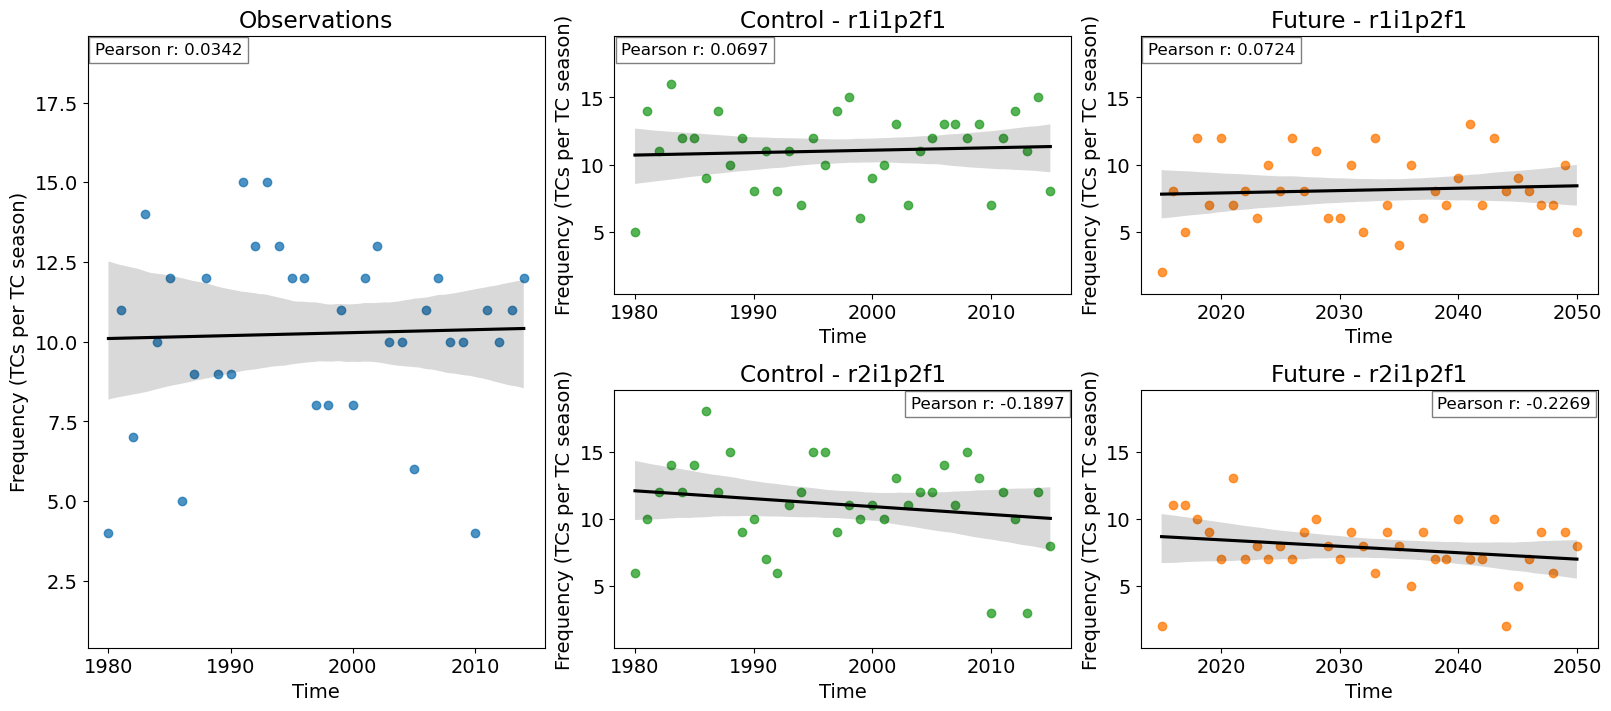

In [122]:
plot_regression('season', 'frequency', obs_storms_per_season, control_storms_per_season_e1, control_storms_per_season_e2, future_storms_per_season_e1, future_storms_per_season_e2, 'Time', 'Frequency (TCs per TC season)')

In [123]:
def plot_running_means(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Define color palette
    colors = sns.color_palette("viridis", 3)

    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [0.5, 1]})

    # Create scatterplots and running means for each dataset in a different subplot
    window_size = 5

    # Plot running means for each percentile in obs_data
    for i, p in enumerate([25, 50, 75]):
        obs_running_mean = obs_data[y_col].rolling(window_size, center=True).quantile(p/100)
        sns.lineplot(data=obs_running_mean, x=obs_data[x_col], y=obs_running_mean, ax=axes[0], color=colors[i], ci=None)

    # Plot running means for each percentile in control_data
    for i, p in enumerate([25, 50, 75]):
        control_running_mean = control_data[y_col].rolling(window_size, center=True).quantile(p/100)
        sns.lineplot(data=control_running_mean, x=control_data[x_col], y=control_running_mean, ax=axes[1], color=colors[i], ci=None)

    # Plot running means for each percentile in future_data
    for i, p in enumerate([25, 50, 75]):
        future_running_mean = future_data[y_col].rolling(window_size, center=True).quantile(p/100)
        sns.lineplot(data=future_running_mean, x=future_data[x_col], y=future_running_mean, ax=axes[1], color=colors[i], ci=None)

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')

    # Add a title to the entire figure
    #fig.suptitle("5-year running means of {} vs {} for the 25th, 50th, and 75th percentile".format(x_label, y_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

    # Determine y-axis limits for both subplots
    ymin = min([running_mean.min() for running_mean in [obs_running_mean, control_running_mean, future_running_mean]])
    ymax = max([running_mean.max() for running_mean in [obs_running_mean, control_running_mean, future_running_mean]])

    # Set the same y-axis limits for both subplots
    axes[0].set_ylim([ymin, ymax])
    axes[1].set_ylim([ymin, ymax])

    # Add a legend for the observational dataset
    legend_labels = ['25th Percentile', '50th Percentile', '75th Percentile']
    legend_colors = [colors[0], colors[1], colors[2]]  # Corresponding colors for the legend labels
    axes[0].legend(labels=legend_labels, handles=[plt.Line2D([0], [0], color=c, linestyle='-') for c in legend_colors])

    # Add gridlines to both subplots
    axes[0].grid(True)
    axes[1].grid(True)

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)

    # Set the titles for each subplot
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF           Future - SSP5-8.5 RF \n 1980 - 2014                      2015 - 2050")

    plt.rcParams.update({'font.size': 14})

    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\percentile_{}_{}_2_ensemble.pdf'.format(x_label, y_label.replace('/', '_')), bbox_inches='tight')

    # Display the plot
    plt.show()



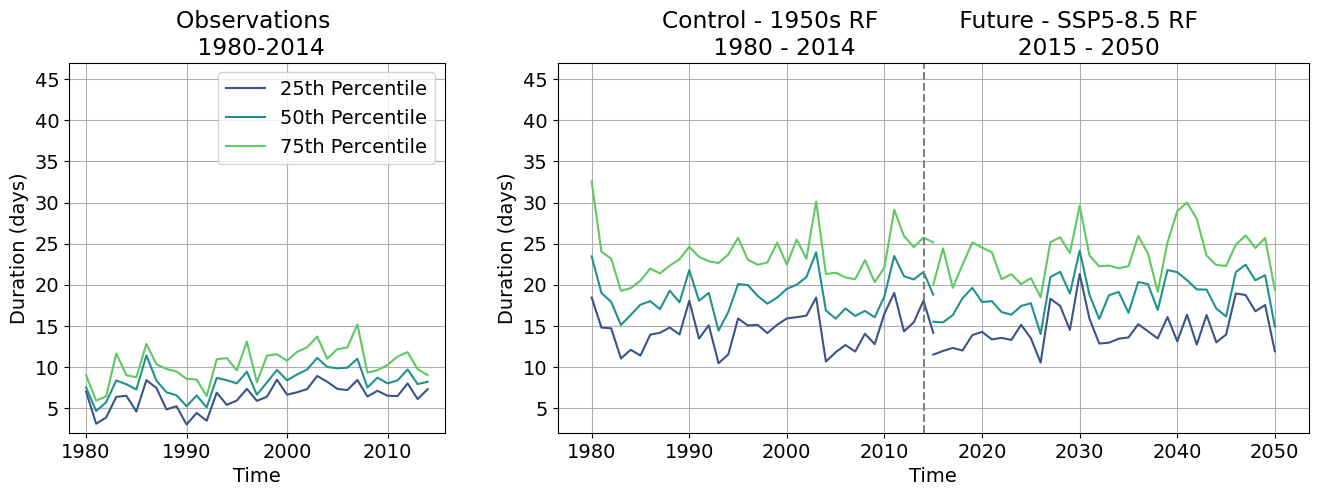

In [124]:
plot_running_means("season","duration", obs_df, control_df, future_df, "Time", "Duration (days)")

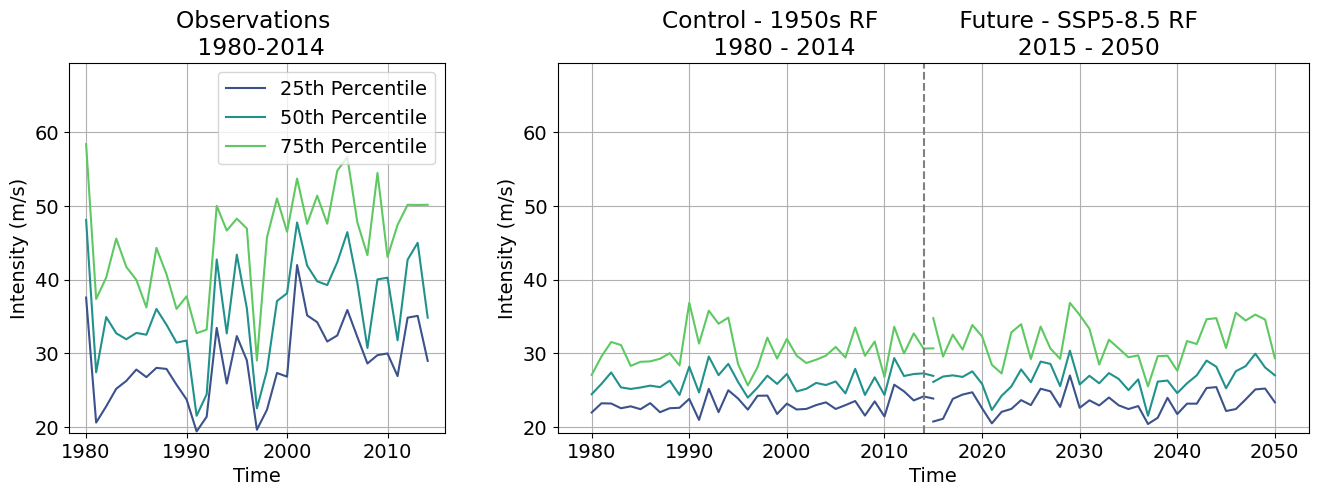

In [125]:
plot_running_means("season","vmax", obs_df, control_df, future_df, "Time", "Intensity (m/s)")

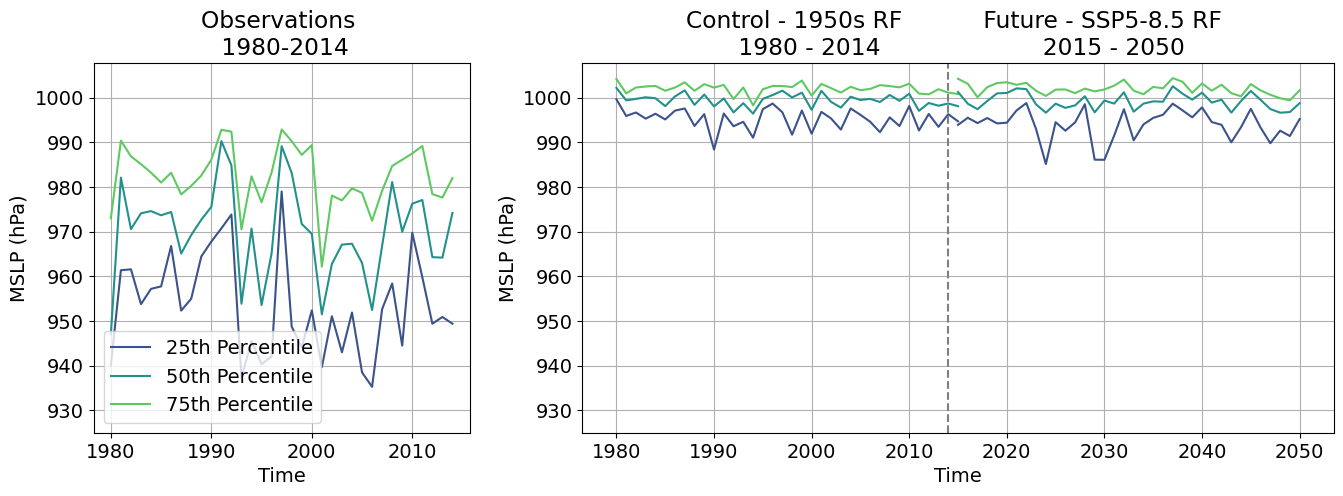

In [126]:
plot_running_means("season", "mslp", obs_df, control_df, future_df, "Time", "MSLP (hPa)")

In [127]:
def calculate_and_print_statistics(data, x_col, y_col):
    # Compute Pearson correlation coefficient
    pearson_coef, _ = stats.pearsonr(data[x_col], data[y_col])
    
    # Perform linear regression and compute p-value
    x = sm.add_constant(data[x_col])
    model = sm.OLS(data[y_col], x).fit()
    p_value = model.pvalues[x_col]

    # Round to 4 significant figures
    pearson_coef = round(pearson_coef, 4)
    p_value = round(p_value, 4)
    
    # Print the results
    print(" Pearson correlation coefficient:", pearson_coef)
    print(" Linear regression p-value:", p_value)
    print()

In [128]:
def plot_distribution(x_col, obs_data, control_data, future_data, bin):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1,2,figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1]})

    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = deep_palette[7]
    

    # Create a KDE plot for each dataset in a different subplot
    sns.histplot(data=obs_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[0],color=obs_color)
    sns.histplot(data=control_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[1],color=control_color)
    sns.histplot(data=future_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[2],color=future_color)

    # Set the titles for each subplot
    axes[0].set_title("Observational 1980-2014")
    axes[1].set_title("Control 1980-2014 & Future 2015-2050")

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')

   
    # Add a title to the entire figure
    #fig.suptitle("Distribution of {}".format(x_col))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

    # Set the same limits for the x-axis in all subplots
    xmin = min(obs_data[x_col].min(), control_data[x_col].min(), future_data[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data[x_col].max(), future_data[x_col].max())
    for ax in axes:
        ax.set_xlim([xmin, xmax])

    ymin = min([ax.get_ylim()[0] for ax in axes])
    ymax = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim([ymin, ymax])

    plt.rcParams.update({'font.size': 14})

    plt.savefig('D:\Masters_Thesis\Report Writing\\figures\distribution_{}_{}_2_ensemble.pdf'.format(x_label, y_label),bbox_inches='tight') 

    # Display the plot
    plt.show()

In [135]:
def plot_storms_distribution(x_col, obs_data, control_data1, control_data2, future_data1, future_data2, x_label, binwidth=1, color=None):
    fig, axes = plt.subplot_mosaic([['left', 'upper center', 'upper right'],
                                    ['left', 'lower center', 'lower right']],
                                   figsize=(16, 7), layout="constrained", gridspec_kw={"width_ratios": [1, 1, 1], "height_ratios": [1, 1]})

    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = deep_palette[7]
    
    
    # Observations plot
    sns.histplot(data=obs_data, x=x_col, binwidth=binwidth, kde=True, ax=axes['left'], color=obs_color)
    axes['left'].set_title("Observations")
    axes['left'].set_xlabel(x_label)

    # Control 1 plot
    sns.histplot(data=control_data1, x=x_col, binwidth=binwidth, kde=True, ax=axes['upper center'], color=control_color)
    axes['upper center'].set_title("Control - r1i1p2f1")
    axes['upper center'].set_xlabel(x_label)

    # Control 2 plot
    sns.histplot(data=control_data2, x=x_col, binwidth=binwidth, kde=True, ax=axes['lower center'], color=control_color)
    axes['lower center'].set_title("Control - r2i1p2f1")
    axes['lower center'].set_xlabel(x_label)

    # Future 1 plot
    sns.histplot(data=future_data1, x=x_col, binwidth=binwidth, kde=True, ax=axes['upper right'], color=future_color)
    axes['upper right'].set_title("Future - r1i1p2f1")
    axes['upper right'].set_xlabel(x_label)

    # Future 2 plot
    sns.histplot(data=future_data2, x=x_col, binwidth=binwidth, kde=True, ax=axes['lower right'], color=future_color)
    axes['lower right'].set_title("Future - r2i1p2f1")
    axes['lower right'].set_xlabel(x_label)

    # Set the titles for each subplot
    axes['left'].set_ylabel('frequency')
    axes['upper center'].set_ylabel('Count')
    axes['lower center'].set_ylabel('Count')
    axes['upper right'].set_ylabel('Count')
    axes['lower right'].set_ylabel('Count')

    # Set the same x-axis limits for all subplots
    xmin = min(obs_data[x_col].min(), control_data1[x_col].min(), control_data2[x_col].min(),
               future_data1[x_col].min(), future_data2[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data1[x_col].max(), control_data2[x_col].max(),
               future_data1[x_col].max(), future_data2[x_col].max())
    for ax in axes.values():
        ax.set_xlim([xmin, xmax])

    # Set the same y-axis limits for all subplots
    ymin = min([ax.get_ylim()[0] for ax in axes.values()])
    ymax = max([ax.get_ylim()[1] for ax in axes.values()])
    y_padding = 0.1 * (ymax - ymin)  # Adjust the padding factor as desired
    ymin = min(0, ymin)  # Ensure the lower limit is 0
    ymax += y_padding
    for ax in axes.values():
        ax.set_ylim([ymin, ymax])

    # Save the figure
    plt.savefig('D:\Masters_Thesis\Report_Writing\\figures\distribution_{}._2_ensemble.pdf'.format(x_label), bbox_inches='tight')

    # Perform the Kruskal-Wallis test and add to the plot
    _, p_value = stats.kruskal(obs_data[x_col], control_data1[x_col], control_data2[x_col], future_data1[x_col], future_data2[x_col])
    print("Kruskal-Wallis p-value:", p_value)

    print(p_value)

    # Display the plot
    plt.show()


Kruskal-Wallis p-value: 2.0072885634262407e-08
2.0072885634262407e-08


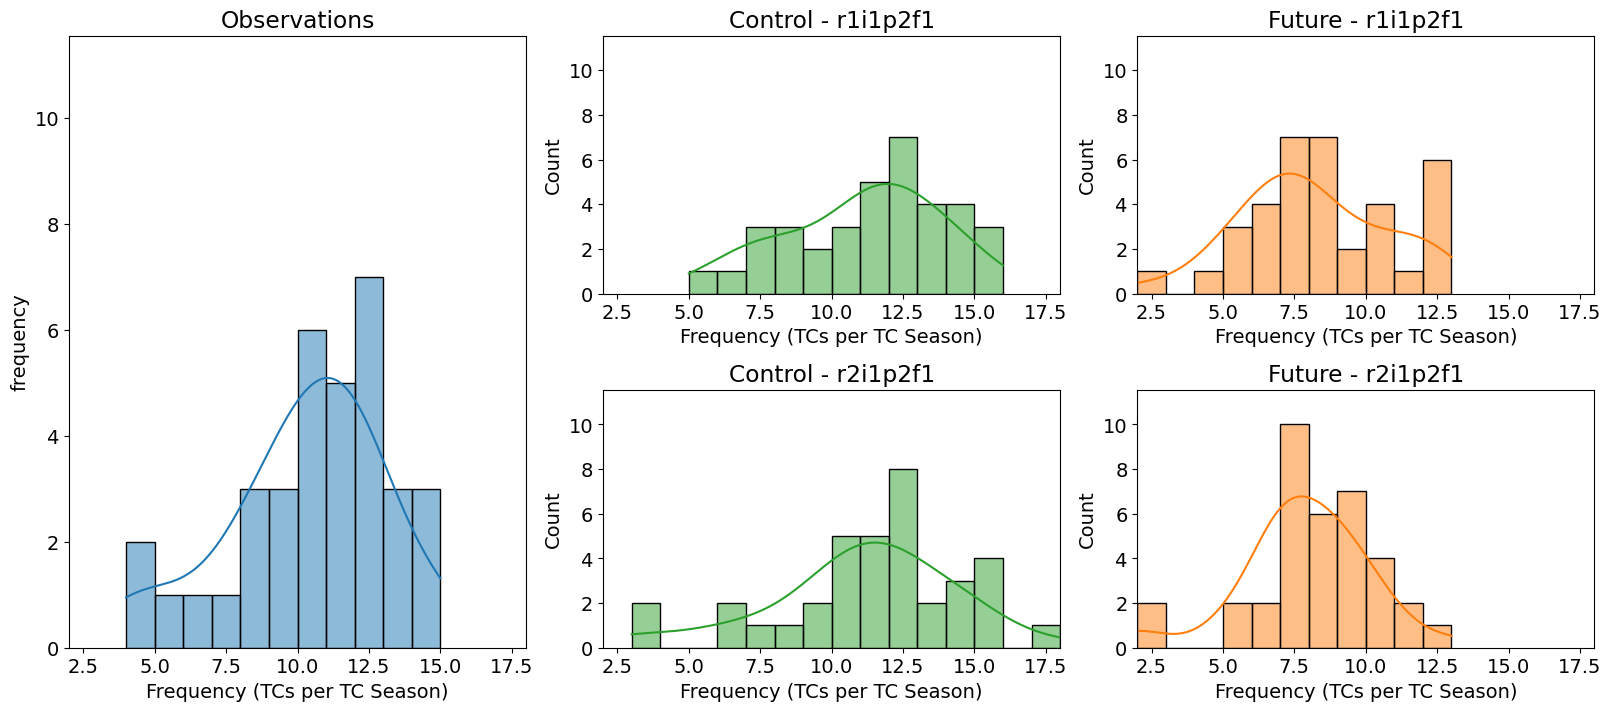

In [136]:
plot_storms_distribution('frequency', obs_storms_per_season, control_storms_per_season_e1, control_storms_per_season_e2, future_storms_per_season_e1, future_storms_per_season_e2, 'Frequency (TCs per TC Season)', binwidth=1, color=None)

In [153]:

import scipy.stats as stats

def plot_storms_distribution(x_col, obs_data, control_data, future_data, x_label,binwidth=1, color=None):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = deep_palette[7]
    

    # Create a KDE plot for each dataset in a different subplot
    sns.histplot(data=obs_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[0],color=obs_color)
    sns.histplot(data=control_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[1],color=control_color)
    sns.histplot(data=future_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[2],color=future_color)

    # Set the titles for each subplot
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF \n 1980-2014")
    axes[2].set_title("Future - SSP5-8.5  RF \n 2015-2050")

    # Set a common x-axis label for all subplots
    # fig.text(0.5, 0.04, 'frequency', ha='center')

    # Add a title to the entire figure
    #fig.suptitle("Distribution of {}".format(x_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, wspace=0.2)

    # Set the same limits for the x-axis in all subplots
    xmin = min(obs_data[x_col].min(), control_data[x_col].min(), future_data[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data[x_col].max(), future_data[x_col].max())
    for ax in axes:
        ax.set_xlim([xmin, xmax])

    ymin = min([ax.get_ylim()[0] for ax in axes])
    ymax = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim([ymin, ymax])

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[1].set_xlabel(x_label)
    axes[2].set_xlabel(x_label)
    

    # Perform the Kruskal-Wallis test and add to the plot
    _, p_value = stats.kruskal(obs_data[x_col], control_data[x_col], future_data[x_col])
    #print("Kruskal-Wallis p-value:", p_value)
    #p_value_str = "Kruskal-Wallis p-value: {}".format(p_value) 
    #axes[1].annotate(p_value_str, xy=(0.5, -0.2), xycoords='axes fraction', ha='center')

    plt.rcParams.update({'font.size': 14})

    # Save figure
    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\distribution_{}._2_ensemble.pdf'.format(x_label.replace('/', '_')), bbox_inches='tight')

    print(p_value)

    # Display the plot
    plt.show()



6.065689132196018e-99


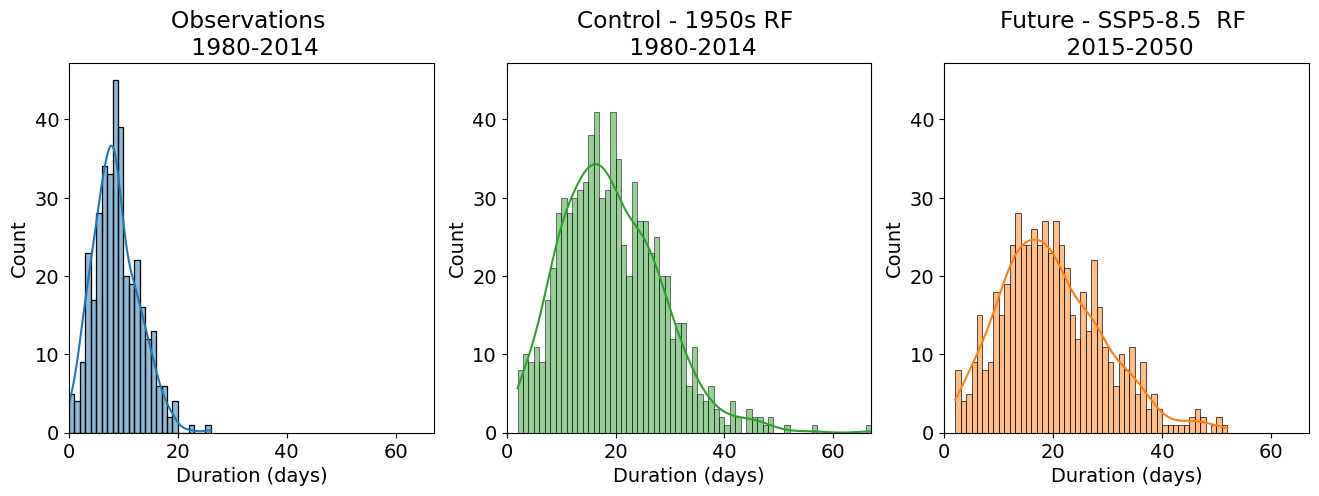

In [154]:
plot_storms_distribution("duration", obs_df, control_df, future_df, "Duration (days)" ,binwidth=1)

1.3215592435210058e-26


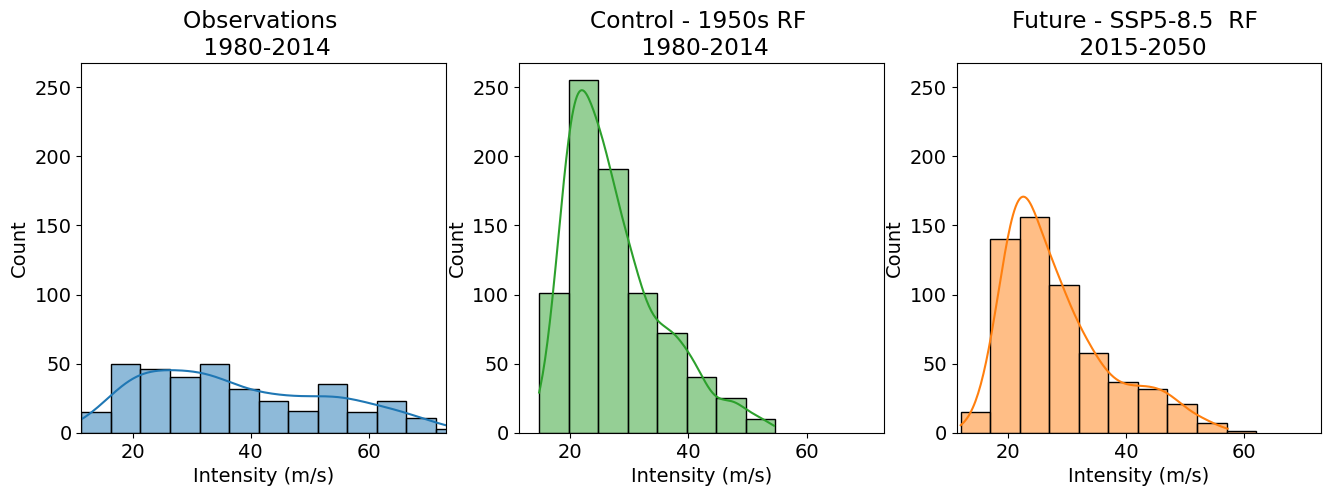

In [155]:
plot_storms_distribution("vmax", obs_df, control_df, future_df,"Intensity (m/s)", binwidth=5)


nan


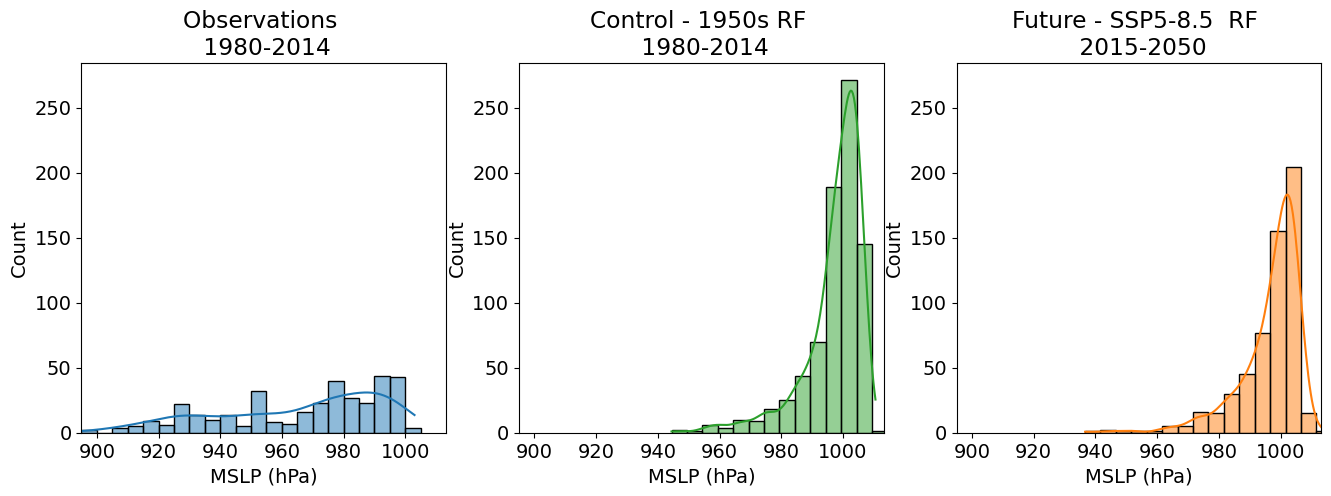

In [156]:
plot_storms_distribution("mslp", obs_df, control_df, future_df,"MSLP (hPa)", binwidth=5)
